In [233]:
import pandas as pd
import matplotlib.pyplot as plt

TIME_COLUMN = "_time"
ENERGY_QTY_COLUMN = "_value"
DRIVER_COLUMN = "driver"
YEAR_COLUMN = "year"
MONTH_COLUMN = "month"

REDUNDANT_COLUMNS = {
    "Unnamed: 0",
    "result",
    "table",
    "_start",
    "_stop",
    "_field",
    "_measurement",
}
EXPECTED_FINAL_COLUMNS = {TIME_COLUMN, ENERGY_QTY_COLUMN, DRIVER_COLUMN}

In [234]:
df: pd.DataFrame = pd.read_csv("input/data.csv", comment="#")
df: pd.DataFrame = df.drop(columns=REDUNDANT_COLUMNS, errors="ignore")

assert (
    set(df.columns) == EXPECTED_FINAL_COLUMNS
), f"Input csv structure has been changed. actual={df.columns.to_list()}"

df[TIME_COLUMN] = pd.to_datetime(df[TIME_COLUMN])
df[MONTH_COLUMN] = df[TIME_COLUMN].dt.month
df[YEAR_COLUMN] = df[TIME_COLUMN].dt.year

DRIVERS: list[str] = list(set(df[DRIVER_COLUMN]))
YEARS: list[int] = list(set(df[YEAR_COLUMN]))
df

,_time,_value,driver,month,year
0,2021-01-01 16:00:00+00:00,51.60,Driver 1,1,2021
1,2021-01-05 12:00:00+00:00,55.50,Driver 1,1,2021
2,2021-01-09 16:00:00+00:00,45.80,Driver 1,1,2021
3,2021-01-14 10:00:00+00:00,54.90,Driver 1,1,2021
4,2021-01-20 17:00:00+00:00,54.00,Driver 1,1,2021
...,...,...,...,...,...
276,2021-12-12 10:00:00+00:00,16.23,Driver 5,12,2021
277,2021-12-15 09:00:00+00:00,51.56,Driver 5,12,2021
278,2021-12-23 11:00:00+00:00,24.40,Driver 5,12,2021
279,2021-12-25 11:00:00+00:00,39.24,Driver 5,12,2021


In [235]:
explicit_df = (
    df.groupby([DRIVER_COLUMN, MONTH_COLUMN, YEAR_COLUMN])
    .agg({"_value": ["count", "sum"]})
    .reset_index()
)
explicit_df.columns = [
    DRIVER_COLUMN,
    MONTH_COLUMN,
    YEAR_COLUMN,
    "charging_sessions",
    "total_kwh",
]
explicit_df

,driver,month,year,charging_sessions,total_kwh
0,Driver 1,1,2021,8,402.700
1,Driver 1,2,2021,8,327.600
2,Driver 1,3,2021,14,430.880
3,Driver 1,4,2021,14,527.000
4,Driver 1,5,2021,10,423.360
5,Driver 1,6,2021,17,483.454
6,Driver 1,7,2021,14,492.588
7,Driver 1,8,2021,5,197.010
8,Driver 1,9,2021,4,155.490
9,Driver 1,10,2021,10,366.456


## Month level overview

In [236]:
def plot_monthly_overview(df: pd.DataFrame, driver: str, year: int):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.bar(
        df["month"],
        df["charging_sessions"],
        color="blue",
        alpha=0.7,
        label="Charging Sessions",
        width=0.4,
    )
    ax1.set_ylabel("Charging Sessions", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    ax2 = ax1.twinx()
    ax2.plot(df["month"], df["total_kwh"], color="green", marker="o", label="Total kWh")
    ax2.plot(df["month"], df["mean_kwh"], color="orange", marker="o", label="Mean kWh")
    ax2.set_ylabel("Total kWh & Mean kWh", color="black")
    ax2.tick_params(axis="y", labelcolor="black")
    ax2.legend(loc="upper right")

    ax1.set(xlabel="Month")
    ax1.legend(loc="upper left")

    fig.suptitle(f"Metrics for [{driver}] on aggregated in [{year}]")
    plt.show()

### With respect to each driver

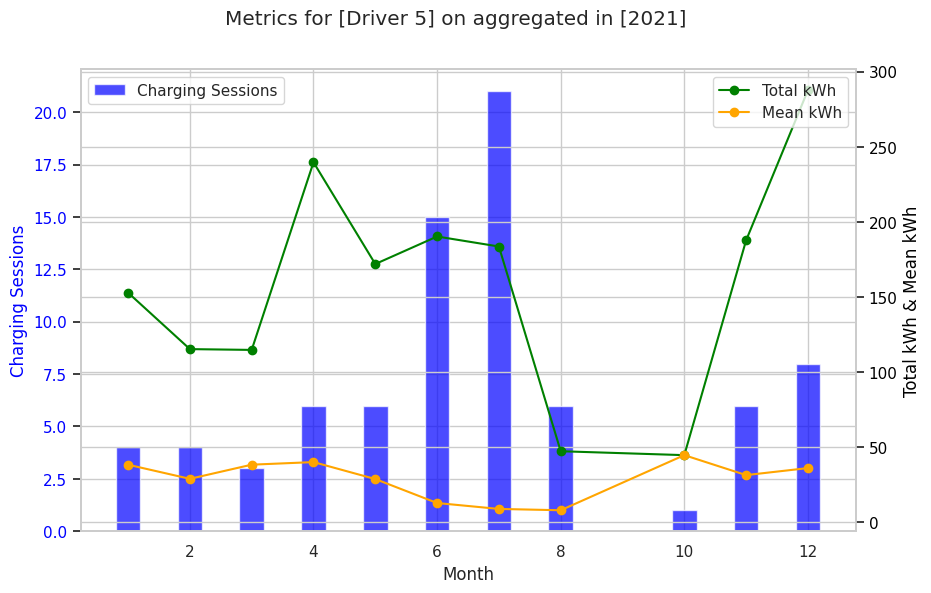

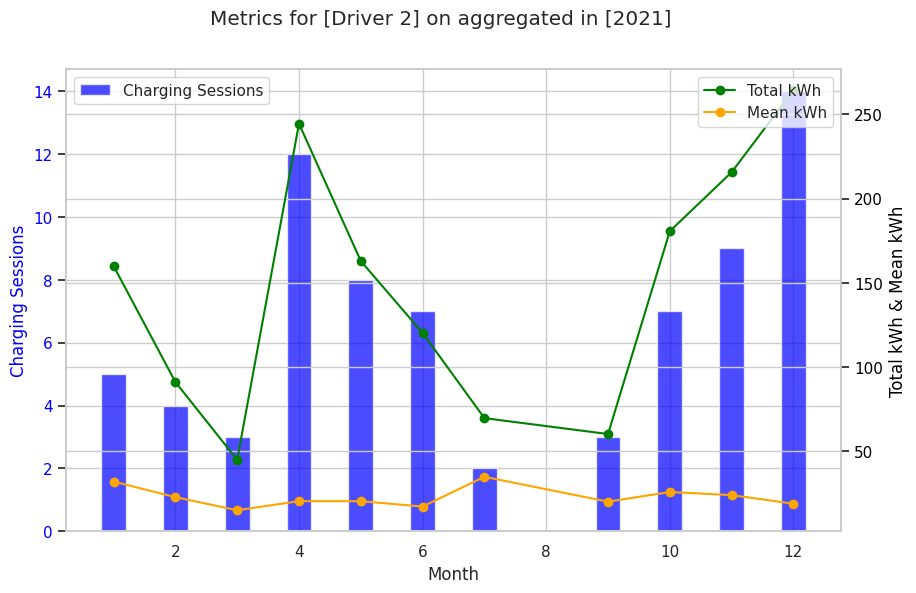

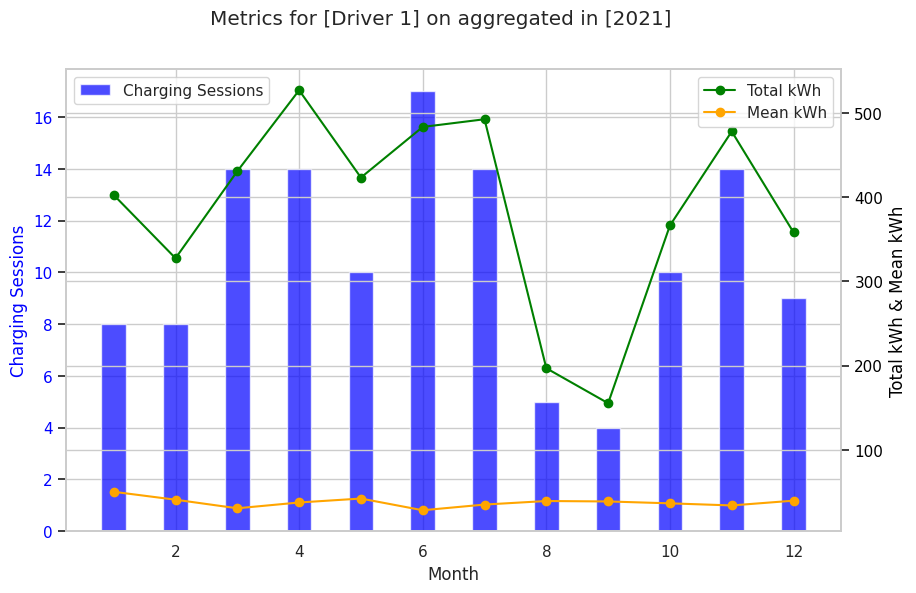

In [237]:
"""
`month_df` will be same as explicit_df because we only have data for 1 year only
"""

month_df = (
    explicit_df.groupby([MONTH_COLUMN, DRIVER_COLUMN, YEAR_COLUMN])
    .agg({"charging_sessions": "sum", "total_kwh": "sum"})
    .reset_index()
)
month_df["mean_kwh"] = month_df["total_kwh"] / month_df["charging_sessions"]

for driver_name in DRIVERS:
    driver_df: pd.DataFrame = month_df[month_df[DRIVER_COLUMN] == driver_name]
    years = set(driver_df[YEAR_COLUMN])
    for year in years:
        plot_monthly_overview(driver_df, driver_name, year)

### With respect to the total fleet

In [238]:
month_df.groupby([MONTH_COLUMN, YEAR_COLUMN]).agg(
    {"charging_sessions": "sum", "total_kwh": "sum"}
).reset_index()

,month,year,charging_sessions,total_kwh
0,1,2021,17,715.480
1,2,2021,16,533.900
2,3,2021,20,590.490
3,4,2021,32,1011.160
4,5,2021,24,758.182
5,6,2021,39,793.943
6,7,2021,37,745.808
7,8,2021,11,244.190
8,9,2021,7,215.720
9,10,2021,18,591.666


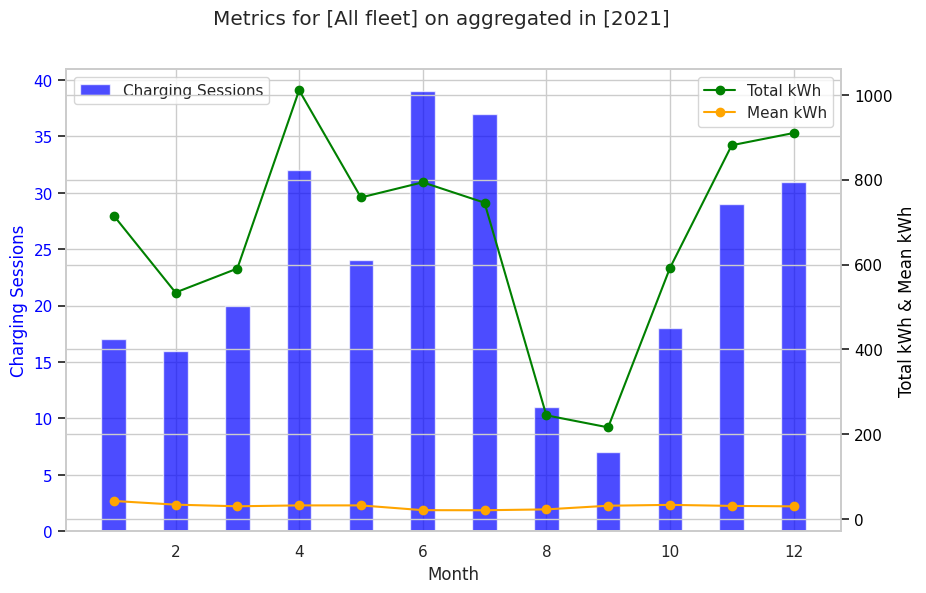

In [239]:
month_fleet_df = (
    month_df.groupby([MONTH_COLUMN, YEAR_COLUMN])
    .agg({"charging_sessions": "sum", "total_kwh": "sum"})
    .reset_index()
)
month_fleet_df["mean_kwh"] = (
    month_fleet_df["total_kwh"] / month_fleet_df["charging_sessions"]
)

years: set[int] = set(month_fleet_df[YEAR_COLUMN])
for year in years:
    plot_monthly_overview(month_fleet_df, "All fleet", year)

## Year level overview

In [240]:
def plot_yearly_overview(all_years_df: pd.DataFrame, year: int):
    df: pd.DataFrame = all_years_df[all_years_df[YEAR_COLUMN] == year]

    df = df.drop(columns=[YEAR_COLUMN])
    columns_to_sum = ["charging_sessions", "total_kwh"]
    df.loc[len(df)] = ["All fleet"] + df[columns_to_sum].sum().tolist()
    df["mean_kwh"] = df["total_kwh"] / df["charging_sessions"]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].bar(df["driver"], df["charging_sessions"], color="blue")
    axs[0].set_title("Charging Sessions")
    axs[0].set_ylabel("Sessions")

    axs[1].bar(df["driver"], df["total_kwh"], color="green")
    axs[1].set_title("Total kWh")
    axs[1].set_ylabel("kWh")

    axs[2].bar(df["driver"], df["mean_kwh"], color="orange")
    axs[2].set_title("Mean kWh")
    axs[2].set_ylabel("kWh")

    fig.suptitle(f"Charging Statistics for [{year}]")

    plt.tight_layout()
    plt.show()

In [241]:
all_years_df = (
    explicit_df.groupby([YEAR_COLUMN, DRIVER_COLUMN])
    .agg({"charging_sessions": "sum", "total_kwh": "sum"})
    .reset_index()
)
all_years_df

,year,driver,charging_sessions,total_kwh
0,2021,Driver 1,127,4642.904
1,2021,Driver 2,74,1614.280
2,2021,Driver 5,80,1734.999


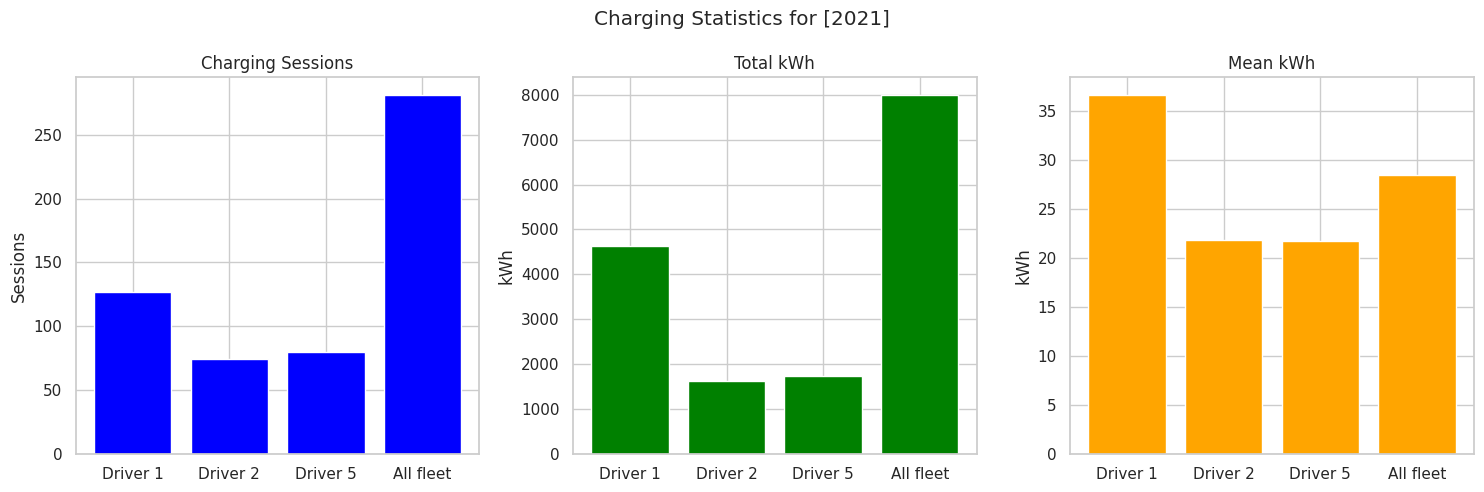

In [242]:
years: set[int] = set(all_years_df[YEAR_COLUMN])
for year in years:
    plot_yearly_overview(all_years_df, year)